In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [18]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

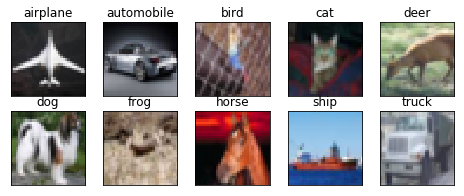

In [19]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### without using space depth.

In [0]:
def depth_wise_sep_conv(no_of_channels, kernel_size, param):
  depth_sep_conv = SeparableConv2D(no_of_channels, kernel_size, padding='same')(param)
  batchnrm = BatchNormalization()(depth_sep_conv)
  actv = ReLU()(batchnrm)
  
  return actv

In [0]:
def normal_conv(no_of_channels, kernel_size, param):
  conv = Conv2D(no_of_channels, kernel_size, padding='same')(param)
  batchnrm = BatchNormalization()(conv)
  actv = ReLU()(batchnrm)
  
  return actv

In [0]:
import tensorflow as tf
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
from keras.layers import Input, Conv2D, ReLU, SeparableConv2D, BatchNormalization, Flatten, MaxPooling2D, Lambda, Activation
from keras.layers.merge import concatenate
from keras.models import Model

input = Input(shape=(32, 32, 3,))

sep1_output = depth_wise_sep_conv(32, 5, input)
conv1_output = normal_conv(32, 5, sep1_output)
conv2_output = normal_conv(32, 5, conv1_output)

sep2_input = concatenate([sep1_output, conv2_output])
sep2_output = depth_wise_sep_conv(32, 5, sep2_input)

mxp_input = concatenate([sep1_output, sep2_output]) 
mxp_output = MaxPooling2D(pool_size=(2, 2), padding ="same", strides=(1,1))(mxp_input)

sep3_output = depth_wise_sep_conv(32, 3, mxp_output)

conv3_input = concatenate([sep1_output, sep2_output, sep3_output])

conv3_output = normal_conv(32, 5, conv3_input)
sep4_input = concatenate([conv2_output, conv3_output, sep3_output, sep2_output])

sep4_output = depth_wise_sep_conv(32, 3, sep4_input)
sep5_input = concatenate([conv2_output, conv3_output, sep1_output, sep2_output, sep3_output, sep4_output])

sep5_output = depth_wise_sep_conv(32, 5, sep5_input)
mxp_input_1 = concatenate([sep5_output, sep4_output, sep3_output, sep2_output, sep1_output])

mxp_output_1 = MaxPooling2D(pool_size=(2,2), padding = 'same', strides=(1,1))(mxp_input_1)
conv4_input = concatenate([conv3_output, mxp_output_1])
conv4_output = normal_conv(32, 5, conv4_input)

sep6_input = concatenate([conv4_output, sep4_output, conv1_output, sep1_output])
sep6_output = depth_wise_sep_conv(32, 5, sep6_input)

conv5_input = concatenate([sep6_output, conv4_output, sep3_output, conv2_output, conv1_output])
conv5_output = normal_conv(32, 3, conv5_input)

sep7_input = concatenate([conv5_output, conv2_output, sep4_output, sep6_output, sep2_output, sep1_output, sep3_output])
sep7_output = depth_wise_sep_conv(32, 5, sep7_input)

# soft_input = Lambda(space_to_depth_x2)(concatenate([sep7_output, sep4_output, sep6_output, sep2_output]))
soft_input_128 = concatenate([sep7_output, sep4_output, sep6_output, sep2_output])

soft_input_64 = Conv2D(64, 32)(soft_input_128)
batchnrm_64 = BatchNormalization()(soft_input_64)
relu_64 = ReLU()(batchnrm_64)

soft_input_10 = Conv2D(10, 1)(relu_64)
batchnrm_10 = BatchNormalization()(soft_input_10)

z = Flatten()(batchnrm_10)
output = Activation('softmax')(z)

model = Model(inputs=[input], outputs=[output])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_121 (Separable (None, 32, 32, 32)   203         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 32, 32, 32)   128         separable_conv2d_121[0][0]       
__________________________________________________________________________________________________
re_lu_214 (ReLU)                (None, 32, 32, 32)   0           batch_normalization_219[0][0]    
__________________________________________________________________________________________________
conv2d_101

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 98s 250ms/step - loss: 1.3372 - acc: 0.5507 - val_loss: 2.6149 - val_acc: 0.3023
Epoch 2/100
390/390 [==============================] - 85s 218ms/step - loss: 0.8963 - acc: 0.7167 - val_loss: 1.2017 - val_acc: 0.5959
Epoch 3/100
390/390 [==============================] - 80s 206ms/step - loss: 0.6813 - acc: 0.7883 - val_loss: 0.9803 - val_acc: 0.6752
Epoch 4/100
390/390 [==============================] - 81s 207ms/step - loss: 0.4950 - acc: 0.8569 - val_loss: 0.8951 - val_acc: 0.7090
Epoch 5/100
390/390 [==============================] - 80s 204ms/step - loss: 0.3077 - acc: 0.9263 - val_loss: 1.1299 - val_acc: 0.6496
Epoch 6/100
390/390 [==============================] - 79s 203ms/step - loss: 0.1638 - acc: 0.9750 - val_loss: 0.9224 - val_acc: 0.7099
Epoch 7/100
390/390 [==============================] - 79s 202ms/step - loss: 0.0881 - acc: 0.9929 - val_loss: 0.8508 - val_acc: 0.7389
Epoch 8/100
390/390 [===========================

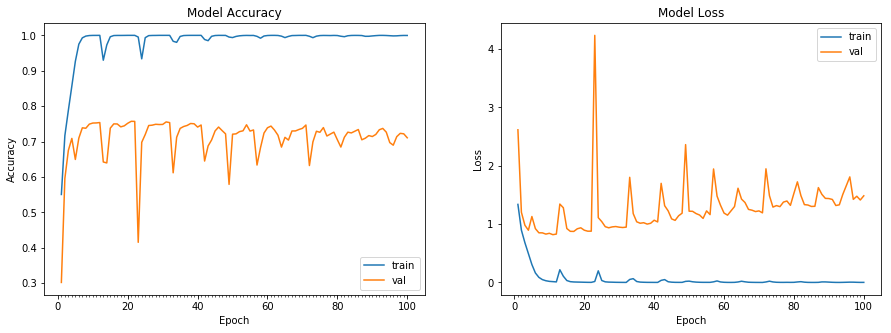

Accuracy on test data is: 71.08


In [49]:
# ENAS log
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Using space_to_depth.

In [0]:
from keras.layers import Input, Conv2D, ReLU, SeparableConv2D, BatchNormalization, Flatten, MaxPooling2D, Lambda, Activation
from keras.layers.merge import concatenate
from keras.models import Model

input = Input(shape=(32, 32, 3,))

sep1_output = depth_wise_sep_conv(32, 5, input)
conv1_output = normal_conv(32, 5, sep1_output)
conv2_output = normal_conv(32, 5, conv1_output)

sep2_input = concatenate([sep1_output, conv2_output])
sep2_output = depth_wise_sep_conv(32, 5, sep2_input)

mxp_input = concatenate([sep1_output, sep2_output]) 
mxp_output = MaxPooling2D(pool_size=(2, 2))(mxp_input)

sep3_output = depth_wise_sep_conv(32, 3, mxp_output)

sep2_output = Lambda(space_to_depth_x2)(sep2_output)
sep1_output = Lambda(space_to_depth_x2)(sep1_output)
conv3_input = concatenate([sep1_output, sep2_output, sep3_output])

conv3_output = normal_conv(32, 5, conv3_input)
conv2_output = Lambda(space_to_depth_x2)(conv2_output)
sep4_input = concatenate([conv2_output, conv3_output, sep3_output, sep2_output])

sep4_output = depth_wise_sep_conv(32, 3, sep4_input)
sep5_input = concatenate([conv2_output, conv3_output, sep1_output, sep2_output, sep3_output, sep4_output])

sep5_output = depth_wise_sep_conv(32, 5, sep5_input)
mxp_input_1 = concatenate([sep5_output, sep4_output, sep3_output, sep2_output, sep1_output])

mxp_output_1 = MaxPooling2D(pool_size=(2,2))(mxp_input_1)
conv3_output = Lambda(space_to_depth_x2)(conv3_output) #

conv4_input = concatenate([conv3_output, mxp_output_1])
conv4_output = normal_conv(32, 5, conv4_input)

conv1_output = Lambda(space_to_depth_x2)(conv1_output)

sep4_output = Lambda(space_to_depth_x2)(sep4_output)
conv1_output = Lambda(space_to_depth_x2)(conv1_output)
sep1_output = Lambda(space_to_depth_x2)(sep1_output)
# sep1 or sep2
sep6_input = concatenate([conv4_output, sep4_output, conv1_output, sep1_output])
sep6_output = depth_wise_sep_conv(32, 5, sep6_input)

sep3_output = Lambda(space_to_depth_x2)(sep3_output)
conv2_output = Lambda(space_to_depth_x2)(conv2_output)

conv5_input = concatenate([sep6_output, conv4_output, sep3_output, conv2_output, conv1_output])
conv5_output = normal_conv(32, 3, conv5_input)

sep2_output = Lambda(space_to_depth_x2)(sep2_output)

sep7_input = concatenate([conv5_output, conv2_output, sep4_output, sep6_output, sep2_output, sep1_output, sep3_output])
sep7_output = depth_wise_sep_conv(32, 5, sep7_input)

soft_input_128 = concatenate([sep7_output, sep4_output, sep6_output, sep2_output])

soft_input_64 = Conv2D(64, 8)(soft_input_128)
batchnrm_64 = BatchNormalization()(soft_input_64)
relu_64 = ReLU()(batchnrm_64)

soft_input_10 = Conv2D(10, 1)(relu_64)
batchnrm_10 = BatchNormalization()(soft_input_10)

z = Flatten()(batchnrm_10)
output = Activation('softmax')(z)

model = Model(inputs=[input], outputs=[z])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_128 (Separable (None, 32, 32, 32)   203         input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_233 (BatchN (None, 32, 32, 32)   128         separable_conv2d_128[0][0]       
__________________________________________________________________________________________________
re_lu_227 (ReLU)                (None, 32, 32, 32)   0           batch_normalization_233[0][0]    
__________________________________________________________________________________________________
conv2d_108

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 55s 141ms/step - loss: 3.7673 - acc: 0.1267 - val_loss: 6.4476 - val_acc: 0.1335
Epoch 2/100
390/390 [==============================] - 45s 116ms/step - loss: 3.5307 - acc: 0.1312 - val_loss: 3.0310 - val_acc: 0.1236
Epoch 3/100
390/390 [==============================] - 45s 116ms/step - loss: 2.8416 - acc: 0.1346 - val_loss: 3.0692 - val_acc: 0.1154
Epoch 4/100
390/390 [==============================] - 45s 116ms/step - loss: 3.2418 - acc: 0.1024 - val_loss: 3.1189 - val_acc: 0.1102
Epoch 5/100
390/390 [==============================] - 45s 116ms/step - loss: 2.6688 - acc: 0.1137 - val_loss: 2.5883 - val_acc: 0.1254
Epoch 6/100
390/390 [==============================] - 45s 116ms/step - loss: 2.5489 - acc: 0.1245 - val_loss: 2.8355 - val_acc: 0.1265
Epoch 7/100
390/390 [==============================] - 45s 116ms/step - loss: 2.5692 - acc: 0.1507 - val_loss: 2.6424 - val_acc: 0.1414
Epoch 8/100
390/390 [===========================

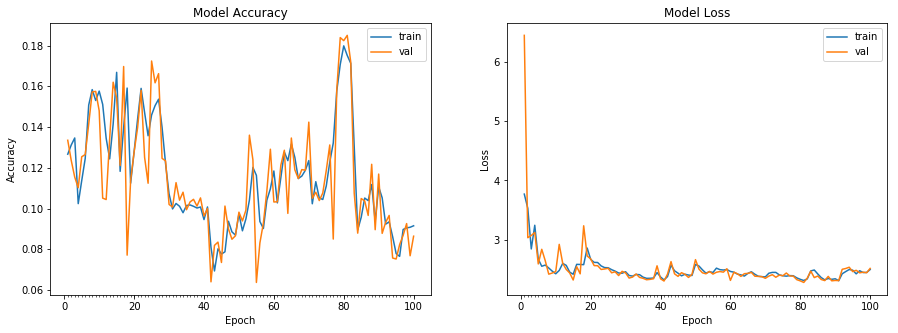

Accuracy on test data is: 8.64


In [52]:
# ENAS log
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))